In [42]:
import eniric
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from eniric.atmosphere import Atmosphere
from eniric.Qcalculator import rv_precision
from eniric.Qcalculator import quality
import colorful as cl
from scipy.signal import find_peaks
%matplotlib notebook

In [43]:
# Read the ESPRESSO file
hdu = fits.open('/home/solene/ESPRESSO_data/molecfit_corr/output/HD41248_1_22_S1D_A_TAC.fits')
data_tell = hdu[1].data
wave = data_tell['wavelength']*0.0001  #(microns)
flux_in = data_tell['flux']
flux_corr = data_tell['tacflux']
trans = data_tell['mtrans']
    # G = 464 nm
    # R = 658 nm 
    # I = 806 nm
    # Z = 900 nm

In [44]:
# Create a mask with False, the artefacts will be marked as True
mask_artefact = np.zeros_like(wave, dtype=bool)
# Define order limits
order_limits = wave[::1000]
order_limits = np.append(order_limits, wave[-1])

In [ ]:
# Write the transmission file
# needs to be written in nanometers
# with open('mtrans_espresso.txt', 'w') as f:
#     for wl, fl in zip(wave, trans):
#         f.write("{} {}\n".format(wl,fl))

<IPython.core.display.Javascript object>


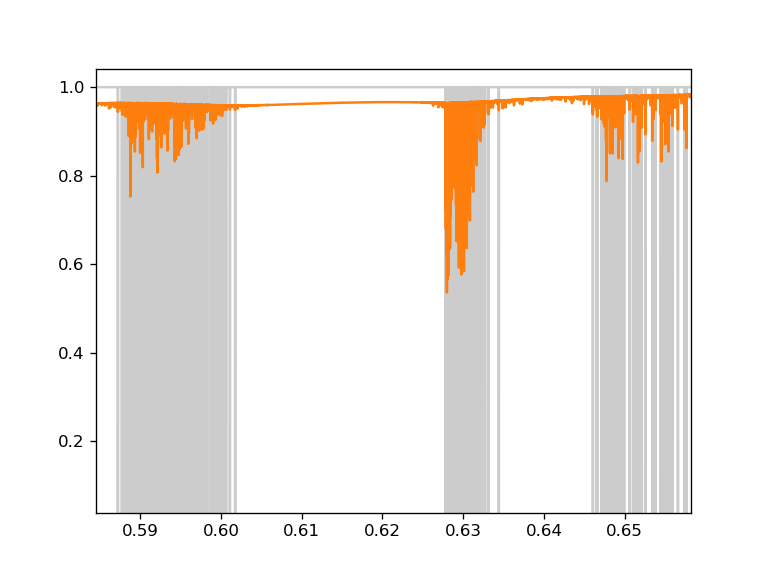

input flux, atm mask:  0.2821123868512783 m / s  > masking the tellurics
corr flux, trans mask: 0.22489571525204238 m / s  > telluric correction
> RV precision is improved

Quality
input flux, atm mask:  9102.246261949538 
corr flux, trans mask: 11251.178143507335
> Quality is improved


In [51]:
# Computing RV precision and Quality
# for all orders, bands Y J and K
# --
# Changing the atmospheric model from TAPAS to Molecfit
eniric.atmmodel["base"] = 'mtrans_HD41248_1_22_S1D'
# Defining the bands
bands = ["VIS", "GAP"]
O2_band = [0.686805, 0.691622]
VIS_mask = (wave > 0.37987386064) & (wave <  0.78025996372) # 0.6798432711)
GAP_mask = (wave > 0.78025996372 ) & (wave < 0.78999790994)
band_masks = [VIS_mask] # , GAP_mask]
qs_bands = []
plt.figure()
# Loop over the bands
# Removing zeros flux points and artefacts
mask = VIS_mask # & (flux_corr > 0.) & ~mask_artefact & ~idx_bad_values_wave
atm = Atmosphere.from_band("VIS", bary=False)
# Obtain closest telluric model values at the wavelength values (telluric mask is super sampled).
atm = atm.at(wave[mask])
# Mask the transmission below given depth. e.g. 2%-5%
atm.mask_transmission(5.0)
    
# Masking the telluric lines
rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
# Corrected tellurics with Molecfit not weighted by the transmission
rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])
print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
if rv_corr_tell < rv_mask_tell:
    print(cl.green('> RV precision is improved'))
else:
    print(cl.red('> RV precision is worsen'))
    
print('\nQuality')
q_mask_tell = quality(wave[mask], flux_in[mask], mask=atm.mask)
q_corr_tell = quality(wave[mask], flux_corr[mask])
print('input flux, atm mask: ', q_mask_tell, 
      '\ncorr flux, trans mask:', q_corr_tell)
if q_corr_tell > q_mask_tell:
    print(cl.green('> Quality is improved'))
else:
    print(cl.red('> Quality is worsen'))
        
    # Computing Quality factor in several intervals
    # needs fixing!!
    # saving all the values (q_mask, q_corr, q_wl) for each band Y, J and H
qs = compute_Q_intervals(wave[mask], flux_in[mask], flux_corr[mask], "VIS")
qs_bands.append(qs)

plt.plot(atm.wl, atm.mask, 'k-', alpha=0.2)
    # plt.plot(wave[mask], flux_in[mask], 'C0-')
plt.plot(wave[mask], trans[mask], 'C1-')
    # plt.plot(wave[mask], flux_corr[mask], 'g.-')
    # plt.plot(wave, mask, 'k.')


(431589,)
(431589,)


<IPython.core.display.Javascript object>


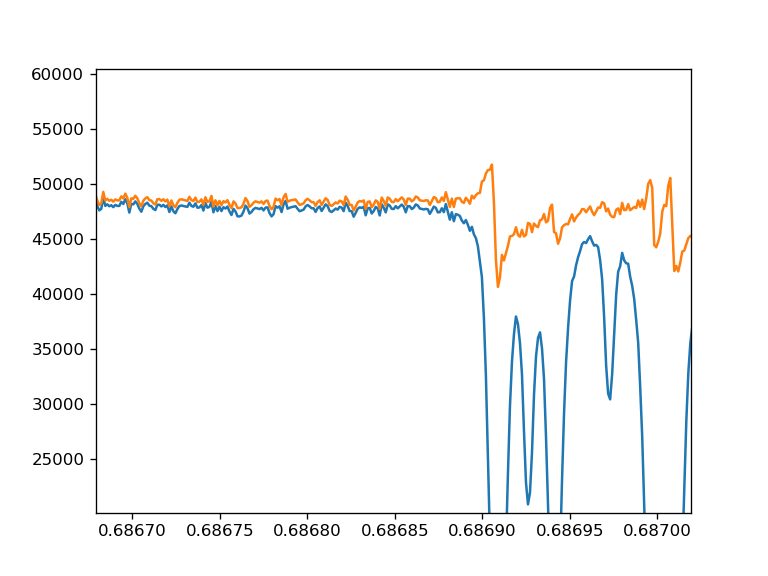

(0.65, 0.8)

In [53]:




print(atm.mask.shape)
print(wave[mask].shape)
# new_mask = mask & atm.mask
plt.figure()
# plt.plot(wave[mask][~atm.mask], flux_in[mask][~atm.mask], 'C0-')
# plt.plot(wave[mask][~atm.mask], flux_corr[mask][~atm.mask], 'g.-')
plt.plot(wave[mask], flux_in[mask])
plt.plot(wave[mask], flux_corr[mask])
plt.xlim(0.65, 0.80)

34074.1641213278


<IPython.core.display.Javascript object>


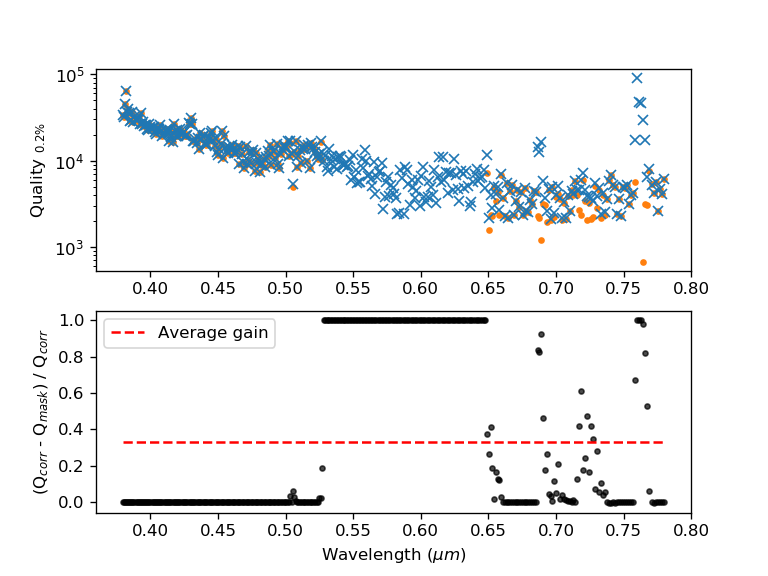

32.885036223364736


In [52]:
# Plotting the Quality factor with telluric liens masked and corrected
# Reproducing the figure 2 of Artigau 2018 
# Qs_bands contains the bands H, J and K with: qs_mask, qs_corr, qs_wl

#qs_bands[0].shape
print(qs_bands[0][0][0])
# print(qs_bands[0][1][0])
# print(qs_bands[0][2][0])

qs_values = qs_bands[0]
plt.figure()
ax1 = plt.subplot(211)
plt.semilogy(qs_bands[0][2], qs_bands[0][0], 'C1.')
# plt.semilogy(qs_bands[1][2], qs_bands[1][0], 'C1.')
# plt.semilogy(qs_bands[2][2], qs_bands[2][0], 'C1.', label='Telluric masked')

plt.semilogy(qs_bands[0][2], qs_bands[0][1], 'C0x')
# plt.semilogy(qs_bands[1][2], qs_bands[1][1], 'C0x')
# plt.semilogy(qs_bands[2][2], qs_bands[2][1], 'C0x', label='Telluric corrected')

# plt.legend()
# plt.plot(wave[mask], atm.mask)
# plt.plot(wave[mask], flux_in[mask])
# plt.axvspan(0.9996668, 1.100366, alpha=0.1)
# plt.axvspan(1.16961, 1.330443, alpha=0.1)
# plt.axvspan(1.4995, 1.750583, alpha=0.1)
plt.ylabel('Quality $_{0.2\%}$')

plt.subplot(212, sharex=ax1)
for i in range(1):
    res_quality = (qs_bands[i][1]-qs_bands[i][0])/qs_bands[i][1]
    plt.plot(qs_bands[i][2], res_quality, 'k.', alpha=0.7)
    plt.plot(qs_bands[i][2], qs_bands[i][2]*0.+np.mean(res_quality), 'r--')
    
plt.plot(0.4,0.4, 'r--', label='Average gain')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('(Q$_{corr}$ - Q$_{mask}$) / Q$_{corr}$')
plt.legend()

print(np.mean((qs_bands[0][1]-qs_bands[0][0])/qs_bands[0][1]*100.))
# print(np.mean((qs_bands[1][1]-qs_bands[1][0])/qs_bands[1][1]*100.))
# print(np.mean((qs_bands[2][1]-qs_bands[2][0])/qs_bands[2][1]*100.))

In [ ]:
# Problems / Future work
# 1. Need to differentiate between fully corrected lines and not fully corrected lines
# 1. Excluding not fully corrected telluric lines
# 2. The RV precision value is wrong because the spectra are not scaled to SNR 100 in J band

In [ ]:
# Reproducing the figure 2 of Artigau 2018 

In [6]:
def compute_Q_intervals(wave, flux_in, flux_corr, band):
    """ 
    Computing the quality factor in several intervals 
    of ~2nm length in each Y, J, and H bands
    
    Reproduces the Figure 2 of Artigau 2018 in the Y, J and H bands
    --------------------------------------------------------------
    INPUTS: 
            wave = wavelength in a given band (Y, J, or H), arr
            flux_in = input flux in the same band, arr
            flux_corr = corrected flux in the same band, arr
            band = name of the band, str
    OUTPUTS: 
            qs_mask = quality factors when the tellurics are masked
            qs_corr = quality factors when the tellurics are corrected
            qs_wl = starting wl of the 2% interval
    """
    my_wl = wave[0]
    qs_mask = []
    qs_corr = []
    qs_wl = []
    while my_wl < wave[-1]:
        # Define wl interval of 2%
        delta_lambda = 0.002*my_wl
        # Mask the regions outside of the interval
        mask_2pc = (wave > my_wl) & (wave < (my_wl+delta_lambda))
        # print(my_wl, delta_lambda, wave[-1])
        
        # Check the wl interval is not falling between two orders
        if np.sum(mask_2pc) == 0:
            # Increment for the next interval
            my_wl = my_wl + delta_lambda
            print('Interval undefined > between 2 orders')
            continue
        else:
            # print('Nb of points in intervals: ', np.sum(mask_2pc), my_wl)
            pass
        
        # Load the atmospheric transmission of Molecfit
        atm = Atmosphere.from_band(band, bary=False)
        # Obtain closest telluric model values at the wavelength values
        atm = atm.at(wave[mask_2pc])
        # Mask the transmission below given depth. e.g. 2%-5%
        atm.mask_transmission(2.0)
        
        # Compute Q over the 2% interval
        q_mask_tell = quality(wave[mask_2pc], flux_in[mask_2pc], mask=atm.mask)
        q_corr_tell = quality(wave[mask_2pc], flux_corr[mask_2pc])
        
        # Save the Qs in two lists
        qs_mask.append(q_mask_tell)
        qs_corr.append(q_corr_tell)
        qs_wl.append(my_wl)
        
        # Increment for the next interval
        my_wl = my_wl + delta_lambda
    return np.array([qs_mask, qs_corr, qs_wl])

In [ ]:
# mask = (wave > 1.17) & (wave < 1.17574)
ind = trans[mask] > 0.97
fl = flux_in[mask]
tr = trans[mask]
ww = wave[mask]
res = fl - tr
# Residuals
avg_res = np.mean(res[ind])
print(avg_res)
max_res = avg_res + np.std(res[ind])
min_res = avg_res - np.std(res[ind])
res_10percent = avg_res*0.1

plt.subplot(212, sharex=ax1)
plt.plot(wave[mask], res, 'C0.')
plt.plot(ww[ind], res[ind], 'C1.')
plt.plot(ww[ind], ww[ind]*0. + max_res, 'k--')
plt.plot(ww[ind], ww[ind]*0. + min_res, 'r--')
plt.plot(ww[ind], ww[ind]*0 + (avg_res + abs(res_10percent)), 'k-')
plt.plot(ww[ind], ww[ind]*0 + (avg_res - abs(res_10percent)), 'r-')

In [ ]:
plt.figure()
wl_mask = Y_mask
# plt.plot(wave[mask], flux_in[mask])
plt.plot(wave, flux_in, 'k-', label='Input')
plt.plot(wave, flux_corr, 'g-', label='Corrected')
plt.plot(wave, data_tell['mtrans'], 'r-', label='Trans')
plt.axvspan(0.9996668, 1.100366, alpha=0.2)
plt.axvspan(1.16961, 1.330443, alpha=0.2)
plt.axvspan(1.4995, 1.750583, alpha=0.2)
# plt.legend()